In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


In [3]:
ds_MPIhist = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001-201412.nc')
ds_MPI245 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_201501-210012.nc')
ds_MPI585 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_201501-210012.nc')

ds_MPI245

<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 192, lon: 384)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by DKRZ is licensed und...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/5d919613-fddc-429a-a6eb-e7b4cb90eaeb
    NCO:                    netCDF Operators version 5.2.4 (Homepage = http:/...

In [4]:
ds_MPI245.tas

<xarray.DataArray 'tas' (time: 1032, lat: 192, lon: 384)>
[76087296 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    height   float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-07-15T20:20:00Z altered by CMOR: Treated scalar dime...

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


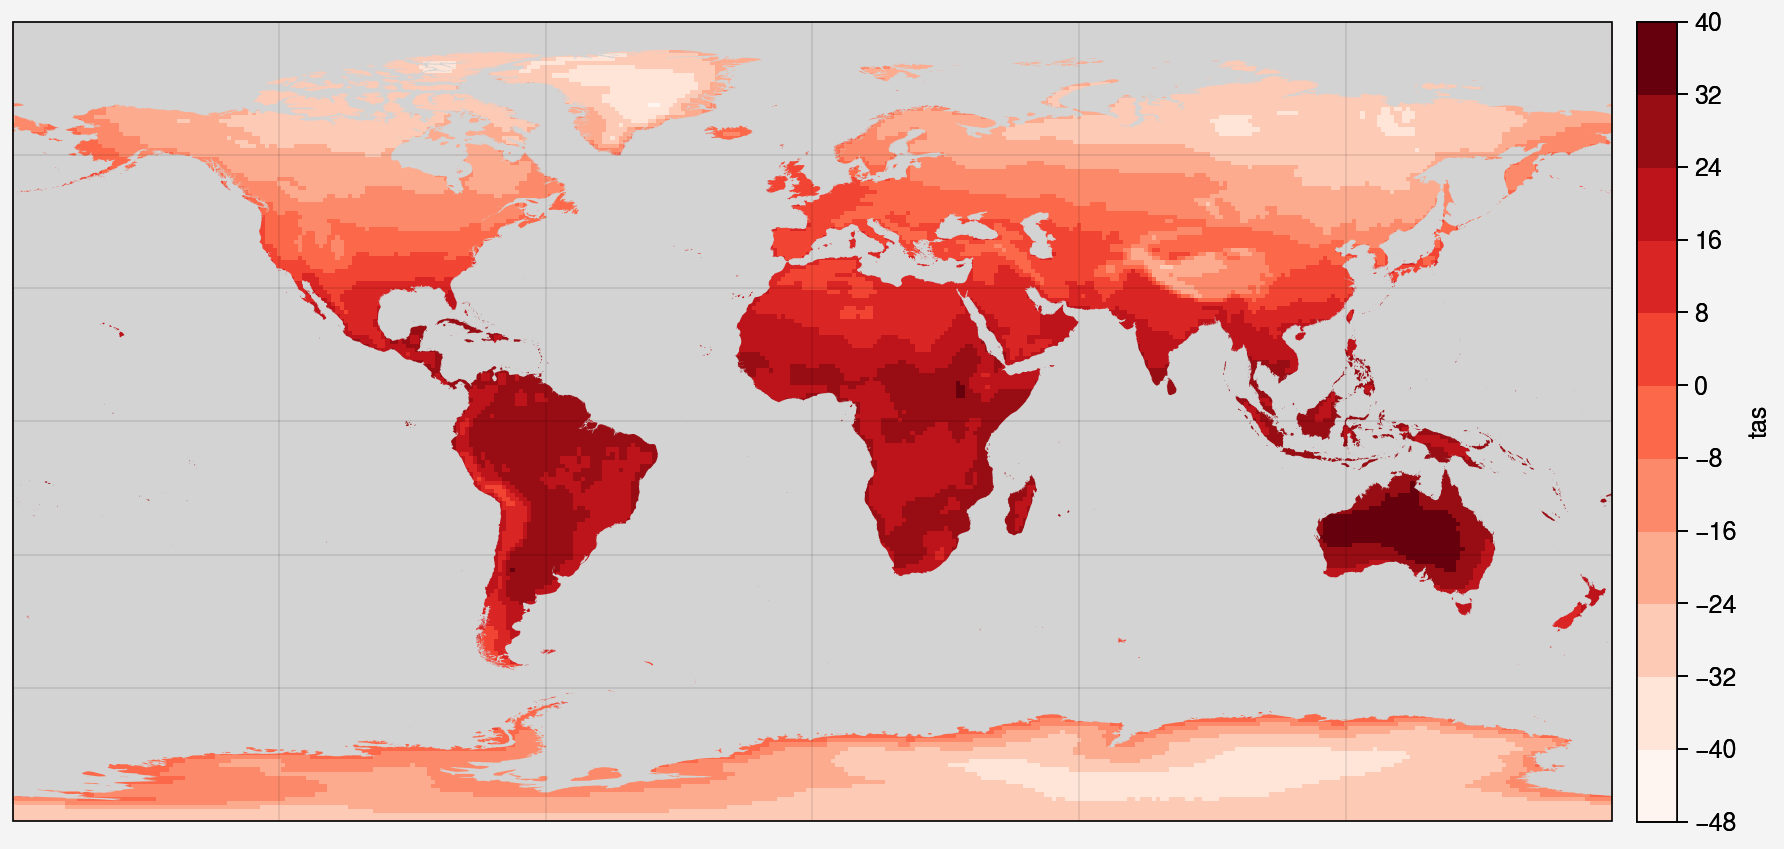

In [5]:
f, axs = pplt.subplots(proj='cyl', axwidth=8)

m=axs.pcolormesh(ds_MPI245.lon, ds_MPI245.lat, ds_MPI245.tas[0]-273.16, levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')

#axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


In [6]:
ds_MPI245_tas = ds_MPI245.tas-273.16

yrly_tas_MPI245_globalmean = u.spatial_average(ds_MPI245_tas.groupby("time.year").mean("time"))
yrly_tas_MPI245_globalmean

<xarray.DataArray (year: 86)>
array([14.88136436, 14.87147446, 14.91429496, 15.06897228, 15.24613977,
       15.15011083, 15.20400806, 15.21839502, 15.14090625, 15.26611132,
       15.2164011 , 15.0473001 , 15.15427587, 15.18020885, 15.39071508,
       15.26187698, 15.20723679, 15.37326619, 15.3803542 , 15.46896474,
       15.44595677, 15.31845755, 15.41147837, 15.41781187, 15.32842563,
       15.51145904, 15.53694489, 15.51563222, 15.34407576, 15.44064934,
       15.52784467, 15.70094873, 15.79862031, 15.76340504, 15.69229318,
       15.75787886, 15.91070832, 15.91403961, 15.73490046, 15.68837326,
       15.64100019, 15.59887302, 15.74051505, 15.95368132, 16.0069925 ,
       15.87146588, 15.73231438, 15.74809362, 16.00376035, 15.98354431,
       15.95397554, 16.1655717 , 15.96835197, 15.88860507, 15.91299893,
       16.10111794, 16.12966168, 16.12224741, 16.21896039, 16.29073621,
       16.2400571 , 16.31166543, 16.17940124, 16.15119672, 16.09455205,
       16.23291628, 16.26938131, 16.20453926, 16.27874186, 16.26525084,
       16.26817701, 16.3604586 , 16.30476143, 16.34076797, 16.36184194,
       16.389293  , 16.30054304, 16.26604528, 16.42617904, 16.40749689,
       16.32805022, 16.40655724, 16.42742453, 16.30403723, 16.2254633 ,
       16.37406945])
Coordinates:
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [7]:
ds_MPI585_tas = ds_MPI585.tas-273.16

yrly_tas_MPI585_globalmean = ds_MPI585_tas.groupby("time.year").mean("time").mean("lat").mean("lon")
yrly_tas_MPI585_globalmean

<xarray.DataArray 'tas' (year: 86)>
array([5.9951777, 6.156788 , 6.106439 , 6.2725234, 6.2980123, 6.308075 ,
       6.174952 , 6.27428  , 6.177016 , 6.211531 , 6.136518 , 6.1571326,
       6.343964 , 6.2156157, 6.3483787, 6.5056458, 6.6541677, 6.4621577,
       6.4322534, 6.560112 , 6.8192673, 6.772261 , 6.7341824, 6.973208 ,
       6.774923 , 6.8996716, 6.8027177, 6.8580985, 7.03723  , 6.9451637,
       6.9055085, 6.85492  , 6.853962 , 7.2393513, 7.275759 , 7.208012 ,
       7.3132553, 7.1253524, 7.351494 , 7.488262 , 7.37743  , 7.547558 ,
       7.6423073, 7.6148515, 7.483227 , 7.663917 , 7.792141 , 7.712992 ,
       7.9130425, 7.759353 , 7.9961867, 7.8437123, 7.935852 , 8.042461 ,
       8.145765 , 8.359252 , 8.196922 , 8.311287 , 8.449689 , 8.525909 ,
       8.395888 , 8.45578  , 8.583959 , 8.403108 , 8.711232 , 8.786216 ,
       8.859988 , 8.908416 , 9.037056 , 8.934896 , 8.978955 , 8.862067 ,
       9.149717 , 9.32399  , 9.309747 , 9.413539 , 9.592528 , 9.520671 ,
       9.671836 , 9.650018 , 9.8150015, 9.786262 , 9.855869 , 9.906857 ,
       9.912788 , 9.920246 ], dtype=float32)
Coordinates:
    height   float64 ...
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [8]:
yrly_tas_MPI585_globalmean = u.spatial_average(ds_MPI585_tas.groupby("time.year").mean("time"))
yrly_tas_MPI585_globalmean

<xarray.DataArray (year: 86)>
array([14.89566611, 14.99626665, 15.01678657, 15.13490424, 15.1550144 ,
       15.1737879 , 15.11322792, 15.20492168, 15.14518945, 15.16139223,
       15.16603472, 15.18713952, 15.22769664, 15.17742797, 15.32665179,
       15.44372147, 15.56917686, 15.35715486, 15.31836684, 15.43680965,
       15.59685788, 15.55297639, 15.49538342, 15.6769031 , 15.55464126,
       15.57871188, 15.52837899, 15.71885904, 15.84265181, 15.69256721,
       15.68237373, 15.62466714, 15.63320387, 15.91387574, 16.10500868,
       16.00868873, 15.9283424 , 15.90161164, 16.07158076, 16.25269153,
       16.15907993, 16.21032786, 16.33340991, 16.34387606, 16.20583836,
       16.35881812, 16.54031581, 16.3909617 , 16.51107478, 16.41634832,
       16.67042599, 16.55766748, 16.51196882, 16.59838462, 16.76307987,
       16.8839437 , 16.79075671, 16.79241808, 17.0320064 , 16.9878584 ,
       16.88630861, 17.00063288, 16.99085061, 16.97090726, 17.23187091,
       17.27291598, 17.29116038, 17.32663159, 17.58789683, 17.44129346,
       17.42504104, 17.38564651, 17.58849551, 17.68794324, 17.6904088 ,
       17.82573945, 18.05579206, 17.97226574, 18.00250757, 18.0459913 ,
       18.10001383, 18.19949075, 18.19944254, 18.27782696, 18.29823855,
       18.21566446])
Coordinates:
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [9]:
ds_MPIhist_tas = ds_MPIhist.tas-273.16

yrly_tas_MPIhist_globalmean = u.spatial_average(ds_MPIhist_tas.groupby("time.year").mean("time"))

In [10]:
del ds_MPIhist,ds_MPI245,ds_MPI585


In [11]:
DJF_tas_MPI245 = u.spatial_average(ds_MPI245_tas.sel(time=ds_MPI245_tas.time.dt.season=="DJF").groupby("time.year").mean("time"))
MAM_tas_MPI245 = u.spatial_average(ds_MPI245_tas.sel(time=ds_MPI245_tas.time.dt.season=="MAM").groupby("time.year").mean("time"))
JJA_tas_MPI245 = u.spatial_average(ds_MPI245_tas.sel(time=ds_MPI245_tas.time.dt.season=="JJA").groupby("time.year").mean("time"))
SON_tas_MPI245 = u.spatial_average(ds_MPI245_tas.sel(time=ds_MPI245_tas.time.dt.season=="SON").groupby("time.year").mean("time"))

allseas_tas_MPI245 = [DJF_tas_MPI245,MAM_tas_MPI245,JJA_tas_MPI245,SON_tas_MPI245]

DJF_tas_MPI585 = u.spatial_average(ds_MPI585_tas.sel(time=ds_MPI585_tas.time.dt.season=="DJF").groupby("time.year").mean("time"))
MAM_tas_MPI585 = u.spatial_average(ds_MPI585_tas.sel(time=ds_MPI585_tas.time.dt.season=="MAM").groupby("time.year").mean("time"))
JJA_tas_MPI585 = u.spatial_average(ds_MPI585_tas.sel(time=ds_MPI585_tas.time.dt.season=="JJA").groupby("time.year").mean("time"))
SON_tas_MPI585 = u.spatial_average(ds_MPI585_tas.sel(time=ds_MPI585_tas.time.dt.season=="SON").groupby("time.year").mean("time"))

allseas_tas_MPI585 = [DJF_tas_MPI585,MAM_tas_MPI585,JJA_tas_MPI585,SON_tas_MPI585]

DJF_tas_MPIhist = u.spatial_average(ds_MPIhist_tas.sel(time=ds_MPIhist_tas.time.dt.season=="DJF").groupby("time.year").mean("time"))
MAM_tas_MPIhist = u.spatial_average(ds_MPIhist_tas.sel(time=ds_MPIhist_tas.time.dt.season=="MAM").groupby("time.year").mean("time"))
JJA_tas_MPIhist = u.spatial_average(ds_MPIhist_tas.sel(time=ds_MPIhist_tas.time.dt.season=="JJA").groupby("time.year").mean("time"))
SON_tas_MPIhist = u.spatial_average(ds_MPIhist_tas.sel(time=ds_MPIhist_tas.time.dt.season=="SON").groupby("time.year").mean("time"))

allseas_tas_MPIhist = [DJF_tas_MPIhist,MAM_tas_MPIhist,JJA_tas_MPIhist,SON_tas_MPIhist]

DJF_tas_MPI245

<xarray.DataArray (year: 86)>
array([13.10641004, 13.08804233, 13.16304458, 13.27273205, 13.38621181,
       13.36457755, 13.37915946, 13.39713854, 13.37876187, 13.60787914,
       13.54730993, 13.20255755, 13.39226953, 13.39355831, 13.47565043,
       13.60430474, 13.47317114, 13.56628885, 13.57947007, 13.82209582,
       13.64483742, 13.61970001, 13.55365976, 13.67212321, 13.49666162,
       13.65123681, 13.77188809, 13.66354892, 13.48256411, 13.58512113,
       13.77377383, 13.83359777, 13.92720693, 14.05618364, 13.90996779,
       13.97922281, 14.26166141, 14.17054177, 13.97437063, 13.90437364,
       13.86806406, 13.79588298, 13.9509326 , 14.27673584, 14.17341593,
       14.04531108, 13.8711746 , 14.00895141, 14.19463277, 14.22450917,
       14.11287208, 14.38141276, 14.40163654, 14.19784681, 14.09413344,
       14.34878329, 14.31505022, 14.402759  , 14.47582432, 14.67779999,
       14.59688003, 14.6168416 , 14.45069122, 14.51797818, 14.47606233,
       14.49073769, 14.5558361 , 14.50787532, 14.6190217 , 14.6561493 ,
       14.46060452, 14.74587976, 14.55743206, 14.57361532, 14.57739172,
       14.73676481, 14.50450777, 14.61664473, 14.76728468, 14.71512239,
       14.64168425, 14.61764921, 14.72578234, 14.62032965, 14.45502726,
       14.65602502])
Coordinates:
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

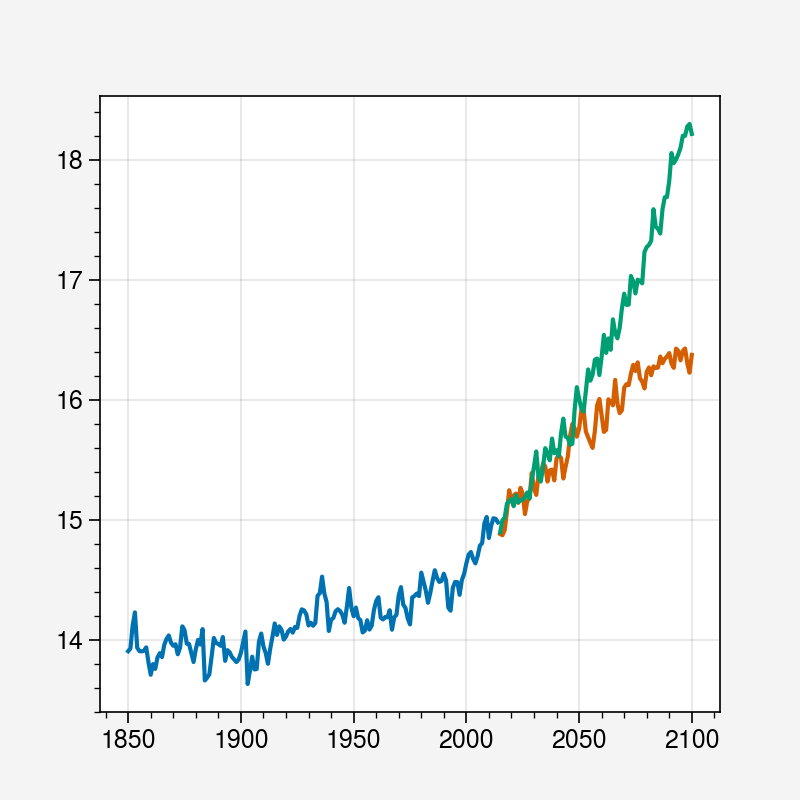

In [12]:
plt.plot(np.arange(1850,2015,1),yrly_tas_MPIhist_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI245_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI585_globalmean)

In [ ]:
#
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_hist.npy', yrly_tas_MPIhist_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp245.npy', yrly_tas_MPI245_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp585.npy', yrly_tas_MPI585_globalmean)

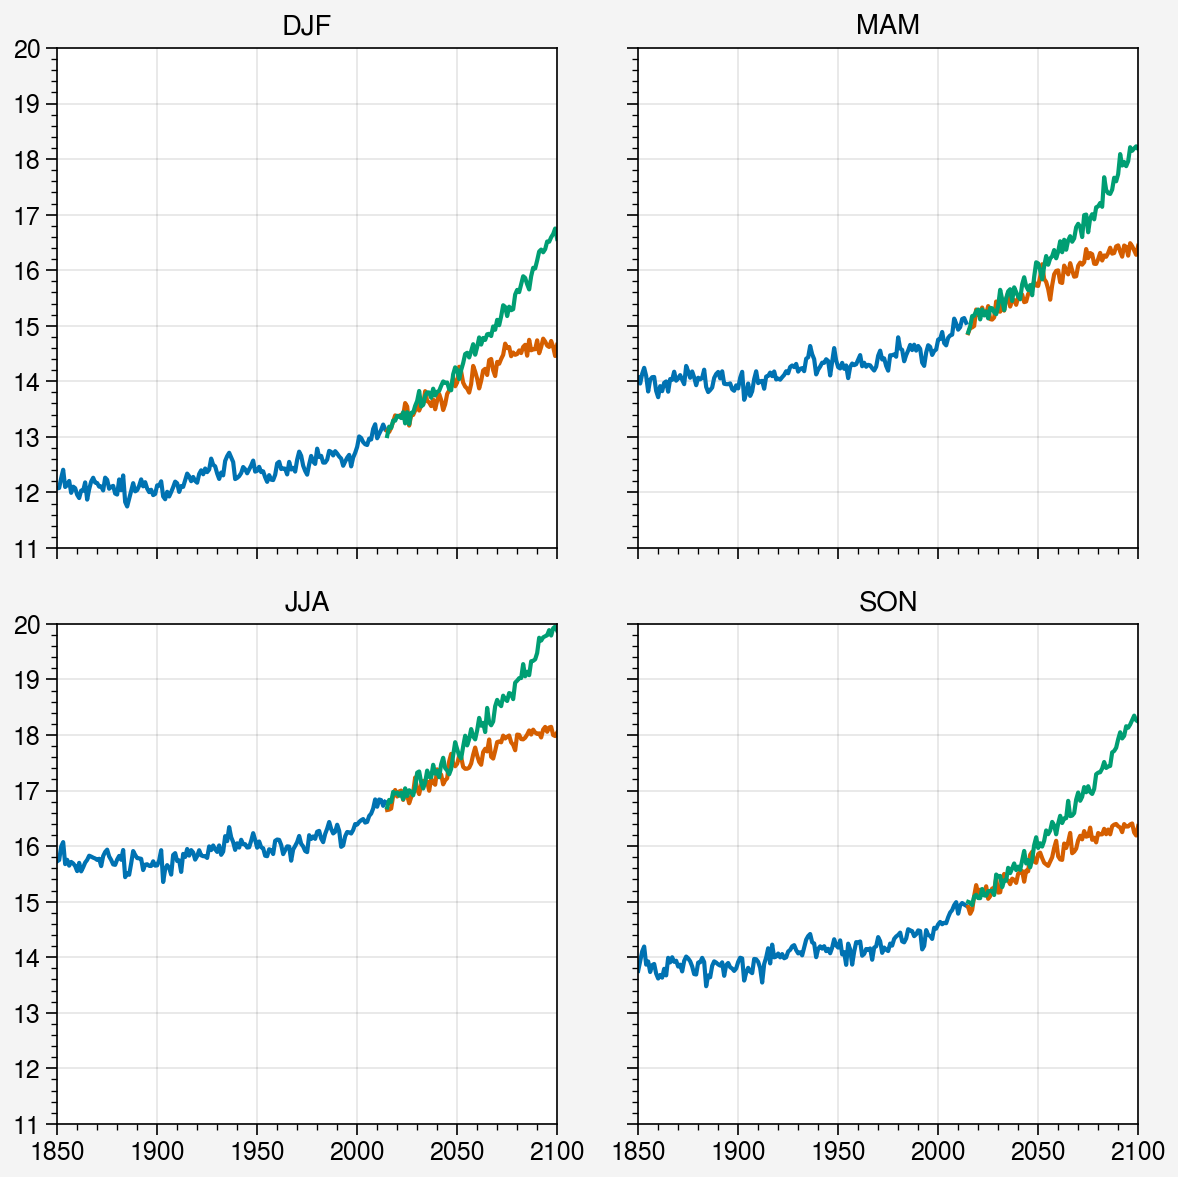

In [14]:
f,axs = pplt.subplots(ncols=2,nrows=2)

seasons = ['DJF','MAM','JJA', 'SON']

for i in range(4):
    ax=axs[i]
    ax.plot(np.arange(1850,2015,1),allseas_tas_MPIhist[i])
    ax.plot(np.arange(2015,2101,1),allseas_tas_MPI245[i])
    ax.plot(np.arange(2015,2101,1),allseas_tas_MPI585[i])
    ax.format(title=seasons[i])
    ax.set_ylim((11.,20))



## EC-Earth3

In [3]:
ds_ECEarth_hist = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_hist_r25i1p1f1_gr_185001-201412.nc')
ds_ECEarth_245 = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_201501-210012.nc')

ds_ECEarth_245

<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP
    branch_time:               0.0
    contact:                   cmip6-data@ec-earth.org
    creation_date:             2019-11-16T07:53:16Z
    data_specs_version:        01.00.27
    ...                        ...
    parent_variant_label:      r1i1p1f1
    branch_method:             standard
    branch_time_in_parent:     60265.0
    branch_time_in_child:      60265.0
    nominal_resolution:        100 km
    history:                   Thu Feb 13 00:35:20 2020: ncatted -O -a calend...

In [4]:
ds_ECEarth_245_tas = ds_ECEarth_245.tas-273.16

del ds_ECEarth_245


yrly_tas_ECEarth_245_globalmean = u.spatial_average(ds_ECEarth_245_tas.groupby("time.year").mean("time"))
yrly_tas_ECEarth_245_globalmean

<xarray.DataArray (year: 86)>
array([15.04987784, 14.97628972, 14.92268655, 15.20586562, 15.18167008,
       15.29297551, 15.27166512, 15.20652872, 15.29693471, 15.2449083 ,
       15.3137223 , 15.28139909, 15.3159761 , 15.43347356, 15.39464582,
       15.46290024, 15.66830378, 15.4057787 , 15.45818865, 15.71626268,
       15.78658336, 15.51132815, 15.70778725, 16.08848493, 15.85993979,
       15.87705276, 15.94790873, 15.78836706, 15.80686446, 15.83785586,
       15.86140945, 16.06993428, 16.02372125, 16.25766962, 16.01434452,
       16.13905971, 16.35841002, 16.09443736, 16.34775778, 16.49199427,
       16.45823063, 16.51703616, 16.39839892, 16.35131812, 16.49732075,
       16.32132667, 16.42986097, 16.64033048, 16.55146433, 16.38238855,
       16.58054466, 16.59667191, 16.78783097, 16.57379919, 16.60185199,
       16.73468784, 16.94973137, 16.93876532, 16.75259771, 16.94136844,
       17.06994937, 16.82077959, 16.92244148, 16.98952118, 17.12104085,
       16.81535546, 16.87981009, 17.03467854, 17.14644597, 17.09880206,
       17.05170696, 17.21132658, 17.04236924, 17.15876873, 17.38939348,
       17.16471555, 17.17212077, 17.37478747, 17.5241419 , 17.29201797,
       17.33520008, 17.52713639, 17.35550148, 17.42952099, 17.7251728 ,
       17.70950674])
Coordinates:
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [5]:
ds_ECEarth_hist_tas = ds_ECEarth_hist.tas-273.16

yrly_tas_ECEarth_hist_globalmean = u.spatial_average(ds_ECEarth_hist_tas.groupby("time.year").mean("time"))
yrly_tas_ECEarth_hist_globalmean

<xarray.DataArray (year: 165)>
array([13.90650064, 13.87232308, 14.02667892, 14.00795739, 14.05639416,
       14.03895702, 13.88180656, 13.87225685, 13.87096162, 13.90139008,
       14.03397313, 14.006959  , 13.74962137, 13.75042547, 13.95248223,
       13.9328129 , 13.98633114, 13.8565093 , 13.95588034, 14.01039811,
       13.97856131, 14.04393992, 13.84006884, 13.85586712, 13.88299887,
       13.81547496, 13.86390803, 13.89471759, 13.75877213, 13.81654676,
       13.84793459, 13.77098876, 13.83660079, 13.71009447, 13.2737273 ,
       13.36978675, 13.48385647, 13.51706902, 13.39976839, 13.44527598,
       13.53530937, 13.47061808, 13.48963789, 13.42362167, 13.5281224 ,
       13.67807766, 13.61763648, 13.54777642, 13.56603752, 13.62773145,
       13.7035506 , 13.61971038, 13.55500264, 13.33928013, 13.42903244,
       13.50979631, 13.50102274, 13.66528065, 13.56510469, 13.51283293,
       13.59072975, 13.69459328, 13.45497857, 13.48625998, 13.39366831,
       13.67603717, 13.69786932, 13.703608  , 13.83783047, 13.8859877 ,
       13.815826  , 13.70579554, 13.88026029, 13.90114679, 13.98327513,
       13.84358718, 13.85285174, 14.05283045, 14.04480557, 14.07882266,
       14.17498742, 14.31925533, 14.19230925, 14.22499872, 14.25031072,
       14.12481075, 14.12875611, 14.15572942, 14.32152366, 14.20487501,
       14.34236754, 14.34631311, 14.4254727 , 14.60015212, 14.44751077,
       14.38589562, 14.5084957 , 14.57328233, 14.56146909, 14.4733369 ,
       14.60721139, 14.65220707, 14.5141626 , 14.4798887 , 14.62278952,
       14.49023005, 14.54031635, 14.39891696, 14.30698659, 14.38065   ,
       14.43848876, 14.47701476, 14.39527236, 14.3388622 , 14.11101125,
       14.05962723, 14.18549661, 14.19230864, 14.2644282 , 14.36108371,
       14.48330972, 14.32535159, 14.37742833, 14.54978418, 14.4470545 ,
       14.25378296, 14.42445854, 14.45373977, 14.38110451, 14.32462611,
       14.49192464, 14.51941915, 14.5995779 , 14.53753279, 14.32791079,
       14.45625226, 14.54658816, 14.46158921, 14.55426083, 14.69151133,
       14.72730091, 14.71304148, 14.31501315, 14.39564029, 14.34491855,
       14.49301571, 14.57024193, 14.65250801, 14.80326777, 14.77548166,
       14.76063078, 14.79784399, 14.82840705, 14.81961137, 14.96657612,
       14.87849003, 14.78854513, 14.82639596, 15.06502691, 14.99716539,
       14.91186492, 15.03393279, 15.05882858, 14.85274814, 15.10984664])
Coordinates:
    height   float64 2.0
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

In [10]:
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_hist.npy', yrly_tas_ECEarth_hist_globalmean)
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_ssp245.npy', yrly_tas_ECEarth_245_globalmean)


In [7]:
yrly_tas_ECEarth_hist_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_hist.npy')
yrly_tas_ECEarth_245_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_ssp245.npy')

In [8]:
yrly_tas_MPIhist_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_hist.npy')
yrly_tas_MPI245_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp245.npy')
yrly_tas_MPI585_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp585.npy')

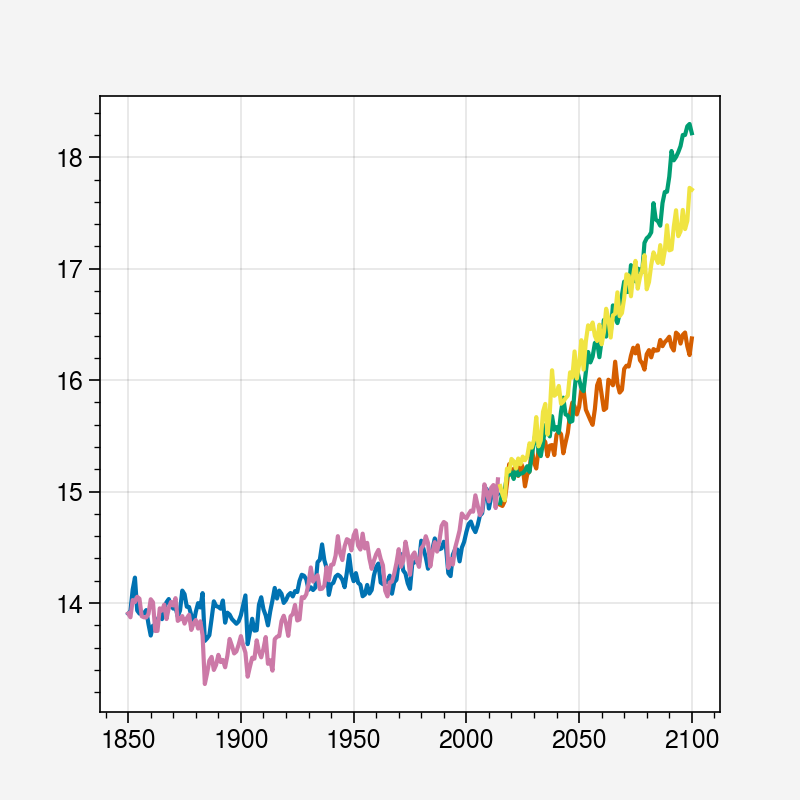

In [9]:
plt.plot(np.arange(1850,2015,1),yrly_tas_MPIhist_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI245_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_MPI585_globalmean)

plt.plot(np.arange(1850,2015,1),yrly_tas_ECEarth_hist_globalmean)
plt.plot(np.arange(2015,2101,1),yrly_tas_ECEarth_245_globalmean)